# Predicting Student Test Scores - Kaggle Competition
## Advanced Ensemble Solution

This notebook implements a comprehensive solution using:
- Advanced feature engineering
- LightGBM, XGBoost, and CatBoost ensemble
- K-fold cross-validation
- Optimized hyperparameters

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported successfully!')

Libraries imported successfully!


In [2]:
# Load data
print('Loading data...')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print('\nFirst few rows:')
train.head()

Loading data...
Train shape: (630000, 13)
Test shape: (270000, 12)

First few rows:


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [3]:
# Data exploration
print('Data Info:')
print(train.info())
print('\nMissing values:')
print(train.isnull().sum())
print('\nTarget statistics:')
print(train['exam_score'].describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB
None

Missing values:
id                  0
age                 0
gender              0
course 

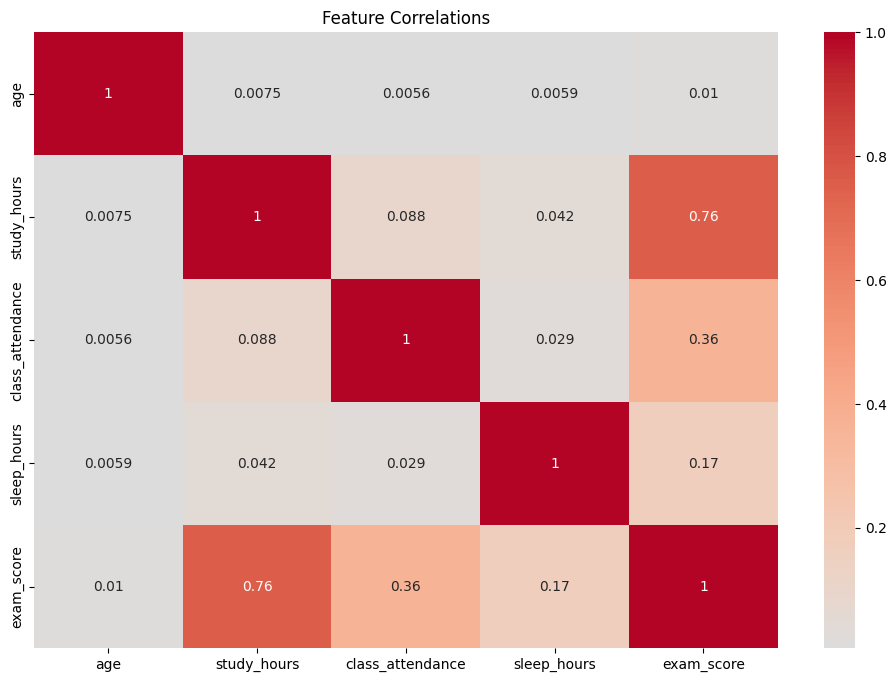


Correlation with target:
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
Name: exam_score, dtype: float64


In [4]:
# Visualize correlations
plt.figure(figsize=(12, 8))
numerical_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']
correlation_matrix = train[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

print('\nCorrelation with target:')
print(train[numerical_cols].corr()['exam_score'].sort_values(ascending=False))

In [5]:
# Advanced Feature Engineering Function
def advanced_feature_engineering(df, is_train=True):
    """
    Create advanced features from the base dataset
    """
    df = df.copy()
    
    # ===== Interaction Features =====
    df['study_attendance_interaction'] = df['study_hours'] * df['class_attendance']
    df['study_sleep_interaction'] = df['study_hours'] * df['sleep_hours']
    df['attendance_sleep_interaction'] = df['class_attendance'] * df['sleep_hours']
    df['study_attendance_sleep'] = df['study_hours'] * df['class_attendance'] * df['sleep_hours']
    
    # ===== Polynomial Features =====
    df['study_hours_squared'] = df['study_hours'] ** 2
    df['study_hours_cubed'] = df['study_hours'] ** 3
    df['class_attendance_squared'] = df['class_attendance'] ** 2
    df['class_attendance_cubed'] = df['class_attendance'] ** 3
    df['sleep_hours_squared'] = df['sleep_hours'] ** 2
    
    # ===== Ratio Features =====
    df['study_per_age'] = df['study_hours'] / (df['age'] + 1)
    df['sleep_per_age'] = df['sleep_hours'] / (df['age'] + 1)
    df['study_sleep_ratio'] = df['study_hours'] / (df['sleep_hours'] + 0.1)
    df['attendance_sleep_ratio'] = df['class_attendance'] / (df['sleep_hours'] + 0.1)
    
    # ===== Log Transformations =====
    df['log_study_hours'] = np.log1p(df['study_hours'])
    df['log_attendance'] = np.log1p(df['class_attendance'])
    df['log_sleep'] = np.log1p(df['sleep_hours'])
    
    # ===== Sqrt Transformations =====
    df['sqrt_study_hours'] = np.sqrt(df['study_hours'])
    df['sqrt_attendance'] = np.sqrt(df['class_attendance'])
    
    # ===== Binning Features =====
    df['age_bin'] = pd.cut(df['age'], bins=[0, 19, 21, 23, 100], labels=[0, 1, 2, 3])
    df['study_hours_bin'] = pd.cut(df['study_hours'], bins=[-1, 2, 4, 6, 10], labels=[0, 1, 2, 3])
    df['attendance_bin'] = pd.cut(df['class_attendance'], bins=[-1, 50, 75, 90, 100], labels=[0, 1, 2, 3])
    df['sleep_bin'] = pd.cut(df['sleep_hours'], bins=[-1, 5, 7, 9, 15], labels=[0, 1, 2, 3])
    
    # ===== Target Encoding (for categorical variables) =====
    if is_train:
        global target_encodings
        target_encodings = {}
        
        if 'exam_score' in df.columns:
            for cat_col in ['gender', 'course', 'study_method', 'exam_difficulty', 'facility_rating', 'sleep_quality', 'internet_access']:
                target_encodings[cat_col] = df.groupby(cat_col)['exam_score'].mean().to_dict()
                df[f'{cat_col}_target_enc'] = df[cat_col].map(target_encodings[cat_col])
    else:
        for cat_col in ['gender', 'course', 'study_method', 'exam_difficulty', 'facility_rating', 'sleep_quality', 'internet_access']:
            df[f'{cat_col}_target_enc'] = df[cat_col].map(target_encodings[cat_col])
    
    # ===== Group Aggregations =====
    if is_train:
        global agg_features
        agg_features = {}
        
        for cat_col in ['gender', 'course', 'study_method', 'exam_difficulty', 'facility_rating', 'sleep_quality']:
            agg_features[f'{cat_col}_mean_study'] = df.groupby(cat_col)['study_hours'].mean().to_dict()
            agg_features[f'{cat_col}_mean_attendance'] = df.groupby(cat_col)['class_attendance'].mean().to_dict()
            agg_features[f'{cat_col}_mean_sleep'] = df.groupby(cat_col)['sleep_hours'].mean().to_dict()
            agg_features[f'{cat_col}_std_study'] = df.groupby(cat_col)['study_hours'].std().to_dict()
            
            df[f'{cat_col}_mean_study'] = df[cat_col].map(agg_features[f'{cat_col}_mean_study'])
            df[f'{cat_col}_mean_attendance'] = df[cat_col].map(agg_features[f'{cat_col}_mean_attendance'])
            df[f'{cat_col}_mean_sleep'] = df[cat_col].map(agg_features[f'{cat_col}_mean_sleep'])
            df[f'{cat_col}_std_study'] = df[cat_col].map(agg_features[f'{cat_col}_std_study'])
    else:
        for cat_col in ['gender', 'course', 'study_method', 'exam_difficulty', 'facility_rating', 'sleep_quality']:
            df[f'{cat_col}_mean_study'] = df[cat_col].map(agg_features[f'{cat_col}_mean_study'])
            df[f'{cat_col}_mean_attendance'] = df[cat_col].map(agg_features[f'{cat_col}_mean_attendance'])
            df[f'{cat_col}_mean_sleep'] = df[cat_col].map(agg_features[f'{cat_col}_mean_sleep'])
            df[f'{cat_col}_std_study'] = df[cat_col].map(agg_features[f'{cat_col}_std_study'])
    
    # ===== Deviation from Group Mean =====
    for cat_col in ['gender', 'course', 'study_method', 'exam_difficulty']:
        df[f'{cat_col}_study_deviation'] = df['study_hours'] - df[f'{cat_col}_mean_study']
        df[f'{cat_col}_attendance_deviation'] = df['class_attendance'] - df[f'{cat_col}_mean_attendance']
    
    return df

print('Feature engineering function defined!')

Feature engineering function defined!


In [6]:
# Apply feature engineering
print('Applying feature engineering...')
train = advanced_feature_engineering(train, is_train=True)
test = advanced_feature_engineering(test, is_train=False)

print(f'Train shape after feature engineering: {train.shape}')
print(f'Test shape after feature engineering: {test.shape}')

Applying feature engineering...
Train shape after feature engineering: (630000, 74)
Test shape after feature engineering: (270000, 73)


In [7]:
# Encode categorical variables
categorical_cols = ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 
                   'facility_rating', 'exam_difficulty', 'age_bin', 'study_hours_bin', 'attendance_bin', 'sleep_bin']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    label_encoders[col] = le

print('Categorical encoding complete!')

Categorical encoding complete!


In [8]:
# Prepare features
feature_cols = [col for col in train.columns if col not in ['id', 'exam_score']]
X = train[feature_cols]
y = train['exam_score']
X_test = test[feature_cols]

print(f'Number of features: {len(feature_cols)}')
print(f'\nFeature list:')
for i, col in enumerate(feature_cols, 1):
    print(f'{i}. {col}')

Number of features: 72

Feature list:
1. age
2. gender
3. course
4. study_hours
5. class_attendance
6. internet_access
7. sleep_hours
8. sleep_quality
9. study_method
10. facility_rating
11. exam_difficulty
12. study_attendance_interaction
13. study_sleep_interaction
14. attendance_sleep_interaction
15. study_attendance_sleep
16. study_hours_squared
17. study_hours_cubed
18. class_attendance_squared
19. class_attendance_cubed
20. sleep_hours_squared
21. study_per_age
22. sleep_per_age
23. study_sleep_ratio
24. attendance_sleep_ratio
25. log_study_hours
26. log_attendance
27. log_sleep
28. sqrt_study_hours
29. sqrt_attendance
30. age_bin
31. study_hours_bin
32. attendance_bin
33. sleep_bin
34. gender_target_enc
35. course_target_enc
36. study_method_target_enc
37. exam_difficulty_target_enc
38. facility_rating_target_enc
39. sleep_quality_target_enc
40. internet_access_target_enc
41. gender_mean_study
42. gender_mean_attendance
43. gender_mean_sleep
44. gender_std_study
45. course_mean_

In [9]:
# Cross-validation setup
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f'Using {n_folds}-fold cross-validation')

Using 5-fold cross-validation


## Model 1: LightGBM

In [10]:
print('='*50)
print('Training LightGBM...')
print('='*50)

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 255,
    'learning_rate': 0.02,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'max_depth': 12,
    'min_child_samples': 20,
    'reg_alpha': 0.05,
    'reg_lambda': 0.05,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1
}

lgb_oof = np.zeros(len(X))
lgb_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'\nFold {fold + 1}/{n_folds}')
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=5000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=200)
        ]
    )
    
    lgb_oof[val_idx] = model.predict(X_val)
    lgb_preds += model.predict(X_test) / n_folds
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgb_oof[val_idx]))
    print(f'Fold {fold + 1} RMSE: {fold_rmse:.6f}')

lgb_cv_rmse = np.sqrt(mean_squared_error(y, lgb_oof))
print(f'\nLightGBM CV RMSE: {lgb_cv_rmse:.6f}')

Training LightGBM...

Fold 1/5
Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 8.69964	valid_1's rmse: 8.81478
[400]	training's rmse: 8.53303	valid_1's rmse: 8.77095
[600]	training's rmse: 8.41152	valid_1's rmse: 8.75804
[800]	training's rmse: 8.30772	valid_1's rmse: 8.75292
Early stopping, best iteration is:
[862]	training's rmse: 8.27789	valid_1's rmse: 8.75261
Fold 1 RMSE: 8.752606

Fold 2/5
Training until validation scores don't improve for 50 rounds
[200]	training's rmse: 8.69824	valid_1's rmse: 8.82086
[400]	training's rmse: 8.53211	valid_1's rmse: 8.77505
[600]	training's rmse: 8.415	valid_1's rmse: 8.76347
[800]	training's rmse: 8.31471	valid_1's rmse: 8.75748
[1000]	training's rmse: 8.21756	valid_1's rmse: 8.75322
[1200]	training's rmse: 8.12633	valid_1's rmse: 8.75049
Early stopping, best iteration is:
[1260]	training's rmse: 8.09868	valid_1's rmse: 8.74991
Fold 2 RMSE: 8.749905

Fold 3/5
Training until validation scores don't improve for 5

## Model 2: XGBoost

In [11]:
print('='*50)
print('Training XGBoost...')
print('='*50)

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 10,
    'learning_rate': 0.02,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'min_child_weight': 1,
    'reg_alpha': 0.05,
    'reg_lambda': 0.05,
    'random_state': 42,
    'tree_method': 'hist',
    'n_jobs': -1
}

xgb_oof = np.zeros(len(X))
xgb_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'\nFold {fold + 1}/{n_folds}')
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=5000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=200
    )
    
    xgb_oof[val_idx] = model.predict(dval)
    xgb_preds += model.predict(xgb.DMatrix(X_test)) / n_folds
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_oof[val_idx]))
    print(f'Fold {fold + 1} RMSE: {fold_rmse:.6f}')

xgb_cv_rmse = np.sqrt(mean_squared_error(y, xgb_oof))
print(f'\nXGBoost CV RMSE: {xgb_cv_rmse:.6f}')

Training XGBoost...

Fold 1/5
[0]	train-rmse:18.64049	val-rmse:18.57049
[200]	train-rmse:8.43032	val-rmse:8.81317
[400]	train-rmse:8.16148	val-rmse:8.77840
[600]	train-rmse:7.97149	val-rmse:8.77033
[800]	train-rmse:7.81081	val-rmse:8.76563
[983]	train-rmse:7.67957	val-rmse:8.76482
Fold 1 RMSE: 8.764819

Fold 2/5
[0]	train-rmse:18.62956	val-rmse:18.61396
[200]	train-rmse:8.43233	val-rmse:8.81904
[400]	train-rmse:8.16549	val-rmse:8.78154
[600]	train-rmse:7.97856	val-rmse:8.77116
[800]	train-rmse:7.81834	val-rmse:8.76772
[1000]	train-rmse:7.67467	val-rmse:8.76579
[1079]	train-rmse:7.62338	val-rmse:8.76556
Fold 2 RMSE: 8.765558

Fold 3/5
[0]	train-rmse:18.62842	val-rmse:18.61897
[200]	train-rmse:8.43242	val-rmse:8.81092
[400]	train-rmse:8.16038	val-rmse:8.77408
[600]	train-rmse:7.97177	val-rmse:8.76575
[800]	train-rmse:7.81366	val-rmse:8.76282
[983]	train-rmse:7.67909	val-rmse:8.76170
Fold 3 RMSE: 8.761700

Fold 4/5
[0]	train-rmse:18.61370	val-rmse:18.67894
[200]	train-rmse:8.42899	val-rms

## Model 3: CatBoost

In [ ]:
print('='*50)
print('Training CatBoost...')
print('='*50)

cat_params = {
    'iterations': 5000,
    'learning_rate': 0.02,
    'depth': 10,
    'l2_leaf_reg': 1,
    'random_seed': 42,
    'verbose': 200,
    'early_stopping_rounds': 50,
    'task_type': 'CPU',
    'thread_count': -1
}

cat_oof = np.zeros(len(X))
cat_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'\nFold {fold + 1}/{n_folds}')
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostRegressor(**cat_params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True
    )
    
    cat_oof[val_idx] = model.predict(X_val)
    cat_preds += model.predict(X_test) / n_folds
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, cat_oof[val_idx]))
    print(f'Fold {fold + 1} RMSE: {fold_rmse:.6f}')

cat_cv_rmse = np.sqrt(mean_squared_error(y, cat_oof))
print(f'\nCatBoost CV RMSE: {cat_cv_rmse:.6f}')

Training CatBoost...

Fold 1/5
0:	learn: 18.6567371	test: 18.5849489	best: 18.5849489 (0)	total: 269ms	remaining: 22m 25s
200:	learn: 8.8573170	test: 8.8588098	best: 8.8588098 (200)	total: 46.9s	remaining: 18m 40s
400:	learn: 8.7919535	test: 8.8229316	best: 8.8229316 (400)	total: 1m 27s	remaining: 16m 45s
600:	learn: 8.7528117	test: 8.8088753	best: 8.8088753 (600)	total: 2m 14s	remaining: 16m 25s
800:	learn: 8.7191244	test: 8.7962663	best: 8.7962663 (800)	total: 2m 53s	remaining: 15m 11s
1000:	learn: 8.6868205	test: 8.7878562	best: 8.7878562 (1000)	total: 3m 32s	remaining: 14m 10s
1200:	learn: 8.6528595	test: 8.7819130	best: 8.7819130 (1200)	total: 4m 35s	remaining: 14m 32s
1400:	learn: 8.6216896	test: 8.7773386	best: 8.7773386 (1400)	total: 5m 44s	remaining: 14m 45s
1600:	learn: 8.5891167	test: 8.7738717	best: 8.7738717 (1600)	total: 7m 10s	remaining: 15m 14s
1800:	learn: 8.5587688	test: 8.7707670	best: 8.7707670 (1800)	total: 8m 14s	remaining: 14m 38s
2000:	learn: 8.5282412	test: 8.7

## Ensemble Optimization

In [ ]:
print('='*50)
print('Finding optimal ensemble weights...')
print('='*50)

best_rmse = float('inf')
best_weights = None

for w1 in np.arange(0.2, 0.5, 0.05):
    for w2 in np.arange(0.2, 0.5, 0.05):
        w3 = 1 - w1 - w2
        if w3 >= 0.2 and w3 <= 0.5:
            ensemble_oof = w1 * lgb_oof + w2 * xgb_oof + w3 * cat_oof
            rmse = np.sqrt(mean_squared_error(y, ensemble_oof))
            if rmse < best_rmse:
                best_rmse = rmse
                best_weights = [w1, w2, w3]

print(f'Best weights: LGB={best_weights[0]:.3f}, XGB={best_weights[1]:.3f}, CAT={best_weights[2]:.3f}')
print(f'Best ensemble CV RMSE: {best_rmse:.6f}')

ensemble_preds = best_weights[0] * lgb_preds + best_weights[1] * xgb_preds + best_weights[2] * cat_preds

## Results Summary

In [ ]:
print('='*50)
print('FINAL RESULTS SUMMARY')
print('='*50)
print(f'LightGBM CV RMSE:  {lgb_cv_rmse:.6f}')
print(f'XGBoost CV RMSE:   {xgb_cv_rmse:.6f}')
print(f'CatBoost CV RMSE:  {cat_cv_rmse:.6f}')
print(f'Ensemble CV RMSE:  {best_rmse:.6f}')
print('='*50)

# Visualize results
models = ['LightGBM', 'XGBoost', 'CatBoost', 'Ensemble']
rmse_scores = [lgb_cv_rmse, xgb_cv_rmse, cat_cv_rmse, best_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_scores, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
plt.ylabel('RMSE Score')
plt.title('Model Performance Comparison')
plt.ylim(min(rmse_scores) * 0.95, max(rmse_scores) * 1.05)
for i, v in enumerate(rmse_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
plt.show()

## Create Submission File

In [ ]:
# Create submission
submission = sample_submission.copy()
submission['exam_score'] = ensemble_preds

submission.to_csv('submission.csv', index=False)
print('Submission file created: submission.csv')
print(f'Submission shape: {submission.shape}')
print('\nFirst few predictions:')
print(submission.head(10))
print('\nPrediction statistics:')
print(f'Mean: {submission["exam_score"].mean():.2f}')
print(f'Std: {submission["exam_score"].std():.2f}')
print(f'Min: {submission["exam_score"].min():.2f}')
print(f'Max: {submission["exam_score"].max():.2f}')

In [ ]:
# Visualize prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y, bins=50, alpha=0.7, label='Train', color='blue')
plt.hist(submission['exam_score'], bins=50, alpha=0.7, label='Predictions', color='orange')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.title('Distribution Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(submission)), submission['exam_score'], alpha=0.5, s=1)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Exam Score')
plt.title('Prediction Scatter Plot')

plt.tight_layout()
plt.show()